In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
from prediction.functions import new_r2

In [2]:
PREDICTION_MODEL = ['lasso', 'ridge', 'enet', 'random_forest', 'lgb', 'nn3']
FS_METHODS = ['all', 'granger', 'huang', 'IAMB', 'mda', 'mdi', 'MMMB', 'sfi']
EVALUATION_START = '2012-07-03'

## Selected Features

In [3]:
# features = []

# for fs in FS_METHODS:
#     assets = glob('results/feature_selection/' + fs + '/indices/*.csv')
#     for asset_path in assets:
#         df = pd.read_csv(asset_path)

#         r2_eval_df = df.copy()
#         r2_eval_df.set_index('date', inplace=True)
#         r2_eval_df = r2_eval_df.loc[EVALUATION_START:]
#         r2 = new_r2(r2_eval_df['return'].values, r2_eval_df['prediction'].values)
#         r2_df = pd.DataFrame([{'model': model,
#                             'fs': fs,
#                             'r2': r2}])
#         r2s.append(r2_df)

#         melt_df = df.melt('date')
#         melt_df['model'] = model
#         melt_df['fs'] = fs
#         predictions.append(melt_df)

# features_df = pd.concat(features, axis=0)

## Aggregate prediction results

In [4]:
predictions = []
r2s = []

for model in PREDICTION_MODEL:
    for fs in FS_METHODS:
        assets = glob('results/forecast/' + fs + '/indices/' + model + '/*.csv')
        for asset_path in assets:
            df = pd.read_csv(asset_path)

            r2_eval_df = df.copy()
            r2_eval_df.set_index('date', inplace=True)
            r2_eval_df = r2_eval_df.loc[EVALUATION_START:]
            r2 = new_r2(r2_eval_df['return'].values, r2_eval_df['prediction'].values)
            r2_df = pd.DataFrame([{'model': model,
                                'fs': fs,
                                'r2': r2}])
            r2s.append(r2_df)

            melt_df = df.melt('date')
            melt_df['model'] = model
            melt_df['fs'] = fs
            predictions.append(melt_df)

predictions_df = pd.concat(predictions, axis=0)
r2_df = pd.concat(r2s, axis=0)

In [5]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.

    :param val: input value
    :type val: float
    :return: css property
    :rtype: str
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color


def show_negative_red(df, round_format):
    """
    show df using the color_negative_red
    function

    :param df: input dataframe
    :type sdf: pd.DataFrame
    :param round_format: number of digits to round float number
    :type round_format: int
    :return: sharpe ratio styler
    :rtype: pd.io.formats.style.Styler
    """
    float_format = '{:.' + '{}'.format(round_format) + "f}"
    return df.style.format(float_format).applymap(color_negative_red)

## R2 -  Gu, Kelly, and Xiu (2020)

In [6]:
pivo = r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100
pivo.columns = ["enet", "lasso", "lgb", "nn3", "random_forest", "ridge"]
pivo = pivo.loc[["all", "sfi", "mdi", "mda", "granger", "huang", "IAMB", "MMMB"],
                ["lasso", "ridge", "enet", "random_forest", "lgb", "nn3"]]

show_negative_red(pivo, 3)

,lasso,ridge,enet,random_forest,lgb,nn3
fs,,,,,,
all,0.261,-888.988,0.261,0.179,0.075,0.258
sfi,0.261,-469.520,0.261,0.188,0.135,-238.008
mdi,0.261,-115.304,0.261,0.257,0.168,-3804.522
mda,0.261,-66.792,0.261,0.314,0.222,-6.347
granger,0.261,-4.881,0.261,0.148,0.177,-0.930
huang,0.162,0.124,0.187,0.228,0.204,-0.141
IAMB,0.261,-3.199,-0.139,-2.251,-0.017,-0.978
MMMB,0.261,-2.444,-0.045,-2.513,-0.153,-2.183


In [7]:
(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).sum(axis=1)

fs
IAMB         -6.324039
MMMB         -7.078099
all        -887.955077
granger      -4.964003
huang         0.764505
mda         -72.081051
mdi       -3918.879365
sfi        -706.684716
dtype: float64

In [8]:
(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).sum(axis=1)/(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).std(axis=1)

fs
IAMB      -4.545295
MMMB      -5.335830
all       -2.446075
granger   -2.435661
huang      5.613025
mda       -2.673048
mdi       -2.537241
sfi       -3.588909
dtype: float64

In [9]:
(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).sum(axis=0)

    model        
r2  enet                1.305721
    lasso               1.986899
    lgb                 0.810251
    nn3             -4052.851343
    random_forest      -3.449642
    ridge           -1551.003730
dtype: float64

In [10]:
(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).sum(axis=0)/(r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2']) * 100).std(axis=0)

    model        
r2  enet              8.070653
    lasso            56.849253
    lgb               6.295214
    nn3              -3.035563
    random_forest    -2.857655
    ridge            -4.809974
dtype: float64

## Return Plots

In [11]:
lasso_df = predictions_df.loc[predictions_df['model'] == 'lasso']
lasso_df = pd.concat([lasso_df.loc[(lasso_df['variable'] == 'return')&(lasso_df['fs'] == 'all')], lasso_df.loc[lasso_df['variable'] == 'prediction']], axis=0)

<AxesSubplot:xlabel='date'>

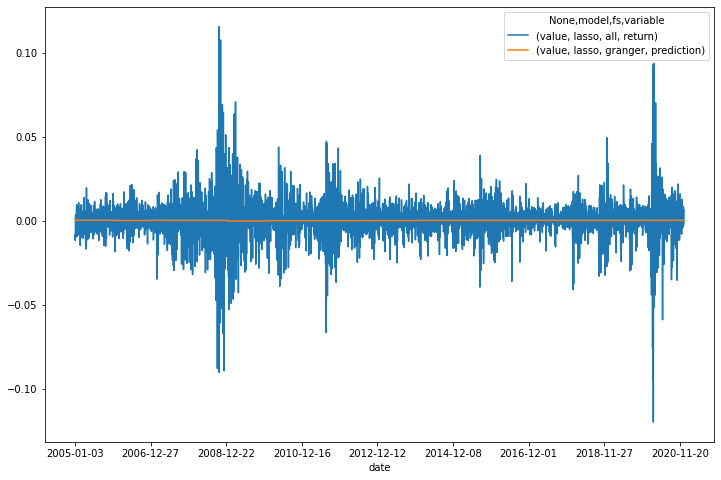

In [12]:
lasso_df.loc[((lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'granger'))|(lasso_df['variable'] == 'return')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

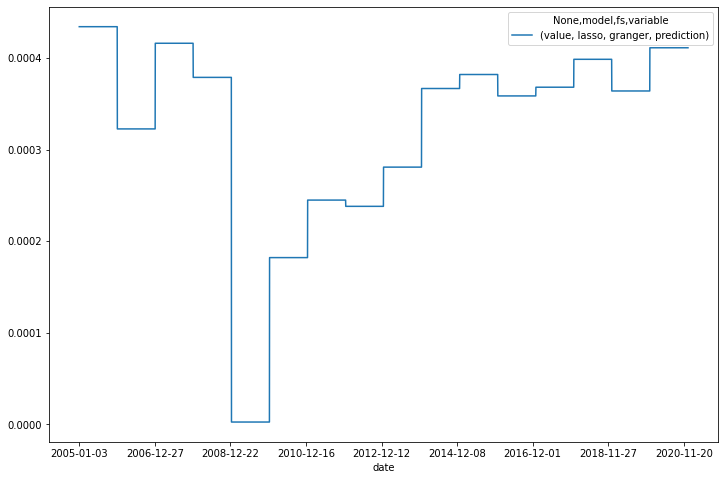

In [13]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'granger')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

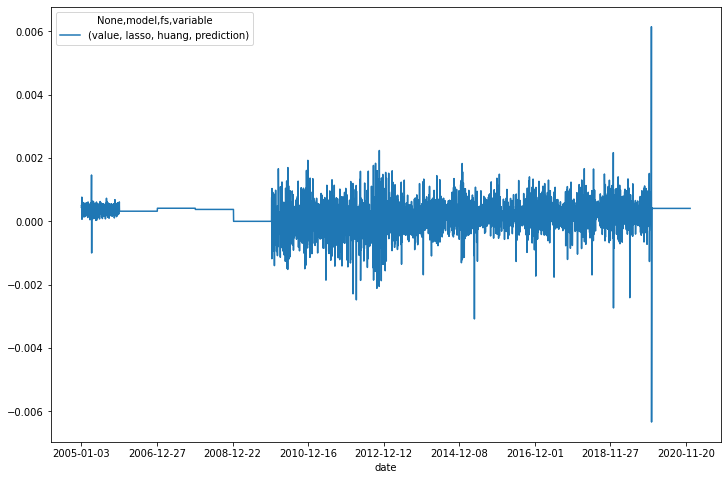

In [14]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'huang')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

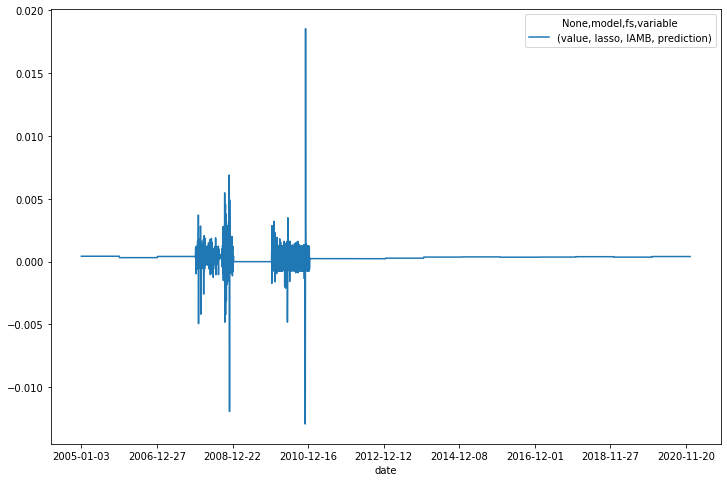

In [15]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'IAMB')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

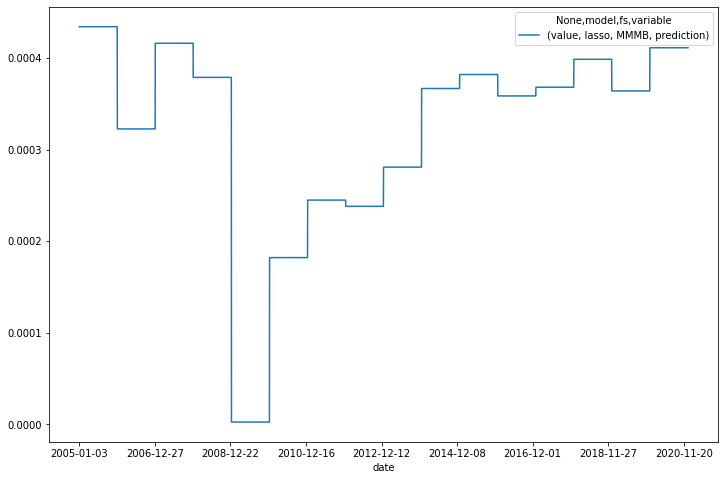

In [16]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'MMMB')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

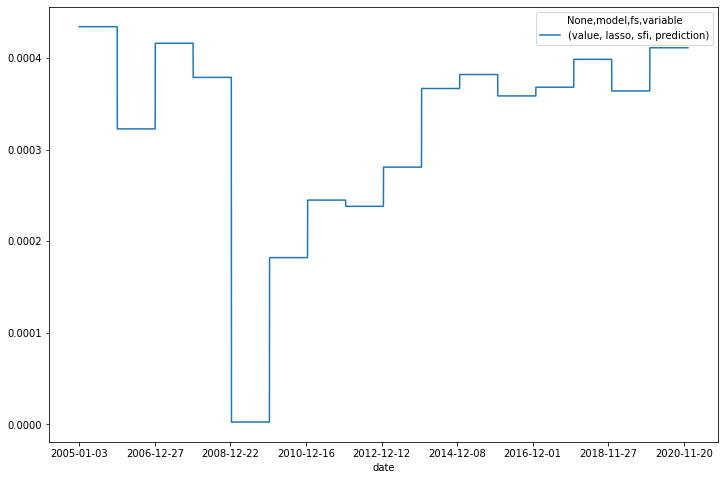

In [17]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'sfi')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

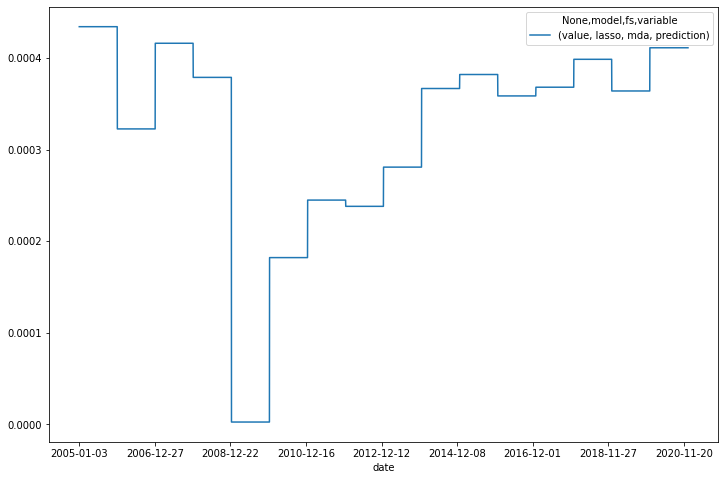

In [18]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'mda')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

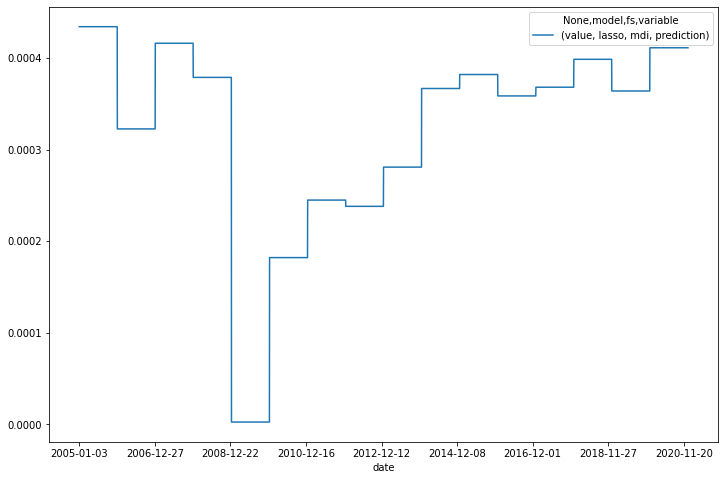

In [19]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'mdi')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))